In [1]:
include("../path.jl")
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry
using Plots

In [2]:
slave_meta_path_2 = "/Users/simon/Data/Sentinel/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE/annotation/s1a-iw3-slc-vv-20170321t054035-20170321t054103-015786-019fee-006.xml"
slave_pod_path_2 = "/Users/simon/Data/Sentinel/S1A_OPER_AUX_POEORB_OPOD_20170410T121606_V20170320T225942_20170322T005942.EOF"
slave_data_path_2 = "/Users/simon/Data/Sentinel/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE/measurement/s1a-iw3-slc-vv-20170321t054035-20170321t054103-015786-019fee-006.tiff"

"/Users/simon/Data/Sentinel/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE/measurement/s1a-iw3-slc-vv-20170321t054035-20170321t054103-015786-019fee-006.tiff"

In [3]:
# load meta and pod
master_meta = Load.slc_meta(slave_meta_path_2);;
master_precise_orbit = Load.precise_orbit(slave_pod_path_2,master_meta["t_0"]);


In [4]:
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

In [5]:
offset=0

0

In [6]:
k_a(x, fm_param, x0) = fm_param[1] .+ fm_param[2].*(x .- x0) .+ fm_param[3].*(x .- x0).^2 # Doppler FM rate, Eqn. 11
f_etac(x, dc_param, x0) = dc_param[1] .+ dc_param[2].*(x .- x0) .+ dc_param[3].*(x .- x0).^2;

In [7]:
meta = slave_meta
pod = slave_precise_orbit
v_mid = mid_burst_speed(pod, meta)

samples = 1:meta["samples_per_burst"]

c = 299792458
k_psi = meta["azimuth_steering_rate"] * pi/180
f_c = meta["radar_frequency"]
lines_per_burst = meta["lines_per_burst"]
number_of_samples = meta["number_of_samples"]
Delta_t_s = meta["azimuth_time_interval"]
Delta_tau_s = 1/meta["range_sampling_rate"]
tau_0 = meta["slant_range_time"]

tau = tau_0 .+ (samples .- 1) .* Delta_tau_s;
tau_mid = tau_0 + meta["samples_per_burst"]/2 * Delta_tau_s
ptau = collect(tau) .- tau_mid 

f = Array{Float64}(undef,meta["burst_count"],length(tau))
eta_ref = Array{Float64}(undef,meta["burst_count"],length(tau))
k_t = Array{Float64}(undef,meta["burst_count"],length(tau))
for n in 1:meta["burst_count"]
    dc_coef = meta["burst_meta"]["data_dc_polynomial"][n, :]
    dc_tau0 = meta["burst_meta"]["data_dc_t0"][n]
    fm_coef = meta["burst_meta"]["azimuth_fm_rate_polynomial"][n, :]
    fm_tau0 = meta["burst_meta"]["azimuth_fm_rate_t0"][n]
    v_s = v_mid[n]
    
    k_s = 2 * v_s/c * f_c * k_psi; # Doppler rate from antenna scanning, Eqn. 4
    alpha = 1 .- k_s ./ k_a(tau, fm_coef, fm_tau0); # conversion factor, Eqn. 3
    k_t[n,:] .= k_s ./ alpha; # Doppler Centroid Rate, Eqn. 2
    
    eta_c = - f_etac(tau, dc_coef, dc_tau0) ./ k_a(tau, fm_coef, fm_tau0); # Beam centre crossing time, Eqn. 7

    eta_ref[n,:] .= eta_c .- (- f_etac(tau_mid, dc_coef, dc_tau0)/k_a(tau_mid, fm_coef, fm_tau0)); # Reference time, Eqn. 6
    
    f_i = f_etac(tau, dc_coef, dc_tau0) 
    f[n,:] .= f_i
end


In [13]:
meta = master_meta
pod = master_precise_orbit
v_mid = mid_burst_speed(pod, meta)

samples = 1:meta["samples_per_burst"]

c = 299792458
k_psi = meta["azimuth_steering_rate"] * pi/180
f_c = meta["radar_frequency"]
lines_per_burst = meta["lines_per_burst"]
number_of_samples = meta["number_of_samples"]
Delta_t_s = meta["azimuth_time_interval"]
Delta_tau_s = 1/meta["range_sampling_rate"]
tau_0 = meta["slant_range_time"]

tau = tau_0 .+ (samples .- 1) .* Delta_tau_s;
tau_mid = tau_0 + meta["samples_per_burst"]/2 * Delta_tau_s
ptau2 = collect(tau) .- tau_mid 

f2= Array{Float64}(undef,meta["burst_count"],length(tau))
eta_ref2 = Array{Float64}(undef,meta["burst_count"],length(tau))
k_t2 = Array{Float64}(undef,meta["burst_count"],length(tau))
k_s = 0
k_a1 = 0
for n in 1:meta["burst_count"]
    dc_coef = meta["burst_meta"]["data_dc_polynomial"][n, :]
    dc_tau0 = meta["burst_meta"]["data_dc_t0"][n]
    fm_coef = meta["burst_meta"]["azimuth_fm_rate_polynomial"][n, :]
    fm_tau0 = meta["burst_meta"]["azimuth_fm_rate_t0"][n]
    v_s = v_mid[n]
    
    k_a1 = k_a(tau, fm_coef, fm_tau0)
    k_s = 2 * v_s/c * f_c * k_psi; # Doppler rate from antenna scanning, Eqn. 4
    alpha = 1 .- k_s ./ k_a(tau, fm_coef, fm_tau0); # conversion factor, Eqn. 3
    k_t2[n,:] .= k_s ./ alpha; # Doppler Centroid Rate, Eqn. 2
    
    eta_c = - f_etac(tau, dc_coef, dc_tau0) ./ k_a(tau, fm_coef, fm_tau0); # Beam centre crossing time, Eqn. 7

    eta_ref2[n,:] .= eta_c .- (- f_etac(tau_mid, dc_coef, dc_tau0)/k_a(tau_mid, fm_coef, fm_tau0)); # Reference time, Eqn. 6
    f2[n,:] .= f_etac(tau, dc_coef, dc_tau0)
end

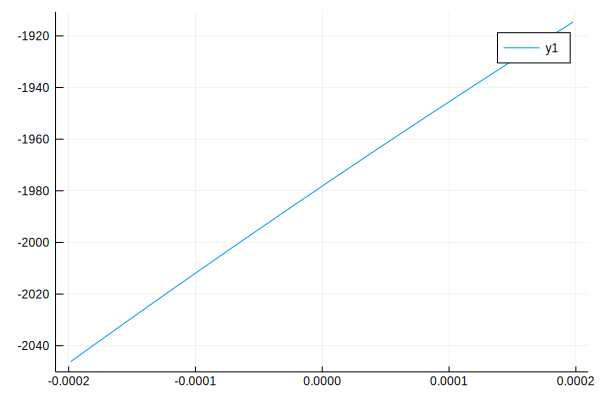

In [21]:
plot(ptau2[1:100:end],k_a1[1:100:end])

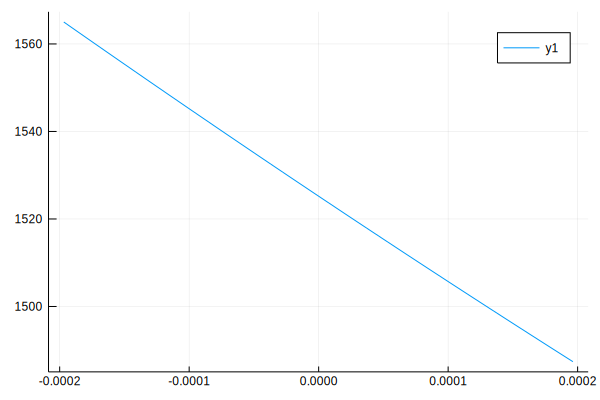

In [10]:
plot(ptau[1:100:end],k_t[2,1:100:end])

In [11]:
k_s

6673.955571492484

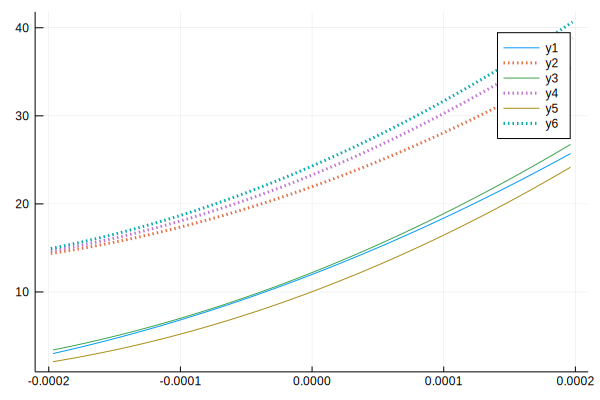

In [9]:
p = plot(ptau[1:100:end],f[2,1:100:end])
plot!(ptau2[1:100:end],f2[2-offset,1:100:end],line=(:dot,3))
for n in 3:4
    plot!(ptau[1:100:end],f[n,1:100:end])
    plot!(ptau2[1:100:end],f2[n-offset,1:100:end],line=(:dot,3))
end
p

In [ ]:
a = (maximum(k_t[1:100:end])-minimum(k_t[1:100:end]))/(maximum(ptau[1:100:end])-minimum(ptau[1:100:end]))
b = 1526
p = plot(ptau[1:100:end],k_t[2,1:100:end].+a.*ptau[1:100:end].-1526)
plot!(ptau2[1:100:end],k_t2[2-offset,1:100:end].+a.*ptau2[1:100:end].-1526,line=(:dot,3))
for n in 3:5
    plot!(ptau[1:100:end],k_t[n,1:100:end].+a.*ptau[1:100:end].-1526)
    plot!(ptau2[1:100:end],k_t2[n-offset,1:100:end].+a.*ptau2[1:100:end].-1526,line=(:dot,3))
end
p

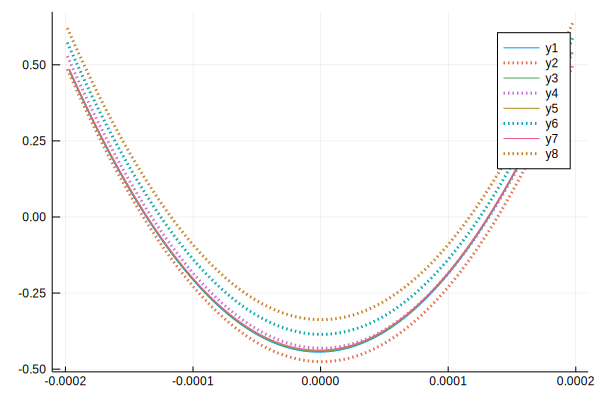

In [253]:
a = (maximum(k_t[1:100:end])-minimum(k_t[1:100:end]))/(maximum(ptau[1:100:end])-minimum(ptau[1:100:end]))
b = 1526
p = plot(ptau[1:100:end],k_t[2,1:100:end].+a.*ptau[1:100:end].-1526)
plot!(ptau2[1:100:end],k_t2[2-offset,1:100:end].+a.*ptau2[1:100:end].-1526,line=(:dot,3))
for n in 3:5
    plot!(ptau[1:100:end],k_t[n,1:100:end].+a.*ptau[1:100:end].-1526)
    plot!(ptau2[1:100:end],k_t2[n-offset,1:100:end].+a.*ptau2[1:100:end].-1526,line=(:dot,3))
end
p

In [254]:
(maximum(k_t[1:100:end])-minimum(k_t[1:100:end]))/(maximum(ptau[1:100:end])-minimum(ptau[1:100:end]))

197537.8629713998

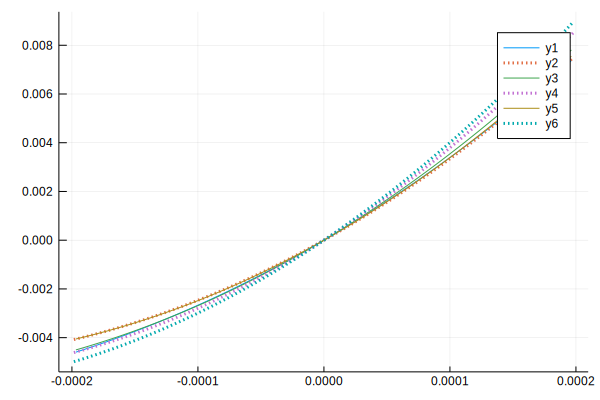

In [255]:
p = plot(ptau[1:100:end],eta_ref[2,1:100:end])
plot!(ptau2[1:100:end],eta_ref2[2-offset,1:100:end],line=(:dot,3))
for n in 3:4
    plot!(ptau[1:100:end],eta_ref[n,1:100:end])
    plot!(ptau2[1:100:end],eta_ref2[n-offset,1:100:end],line=(:dot,3))
end
p

In [43]:
master_meta["range_pixel_spacing"]

2.329562

In [36]:
master_meta["range_pixel_spacing"]/sin(pi/180*master_meta["incidence_angle_mid"])

3.379112059577917

In [25]:
master_meta["azimuth_pixel_spacing"]

13.84805

In [44]:
13.84805/3.379112059577917

4.098132809993213

4.098132809993213

In [41]:
1/master_meta["azimuth_time_interval"]

486.48631029955294

In [42]:
486.48631029955294/(2*pi*2040)

0.037954265211133084